# 2. Investigating Tasks

As shoes play a crucial role in everyone's daily life, they aim to enhance their shoe production and sales. 

In order to provide valuable insights to their marketing and research development department, they seek to gain a comprehensive understanding of their competitors.

In [1]:
import re
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

In [2]:
df = pd.read_csv("cleaned_df.csv", sep="\t")

### 1. Identify the most popular shoe products in the market.

How to define popularity?

1. Number of product reviews per brand per market => ???
2. Avg Ratings of product reviews per brand per market => Tells us what?
3. Number of verified purchased per brand per market => ???
4. Is finding reviews helpful an indicator or brand popularity or customer mindset?
5. Avg. Num of days since product is available based on num of days since Review has been posted
6. Aggregate metric? => ???

#### Deciding which metrics to use

In [37]:
df.columns

Index(['uniq_id', 'product_brand_name', 'product_style_name',
       'product_shoe_gender', 'product_name', 'checked_user_name',
       'verified_purchase', 'review_title', 'review_text', 'review_rating',
       'review_market', 'review_posted_date', 'review_lang',
       'helpful_count_int', 'scraped_date_diff_posted', 'reviewer_name',
       'review_date', 'scraped_at', 'helpful_count', 'url'],
      dtype='object')

Text(0, 0.5, 'Num of reviews')

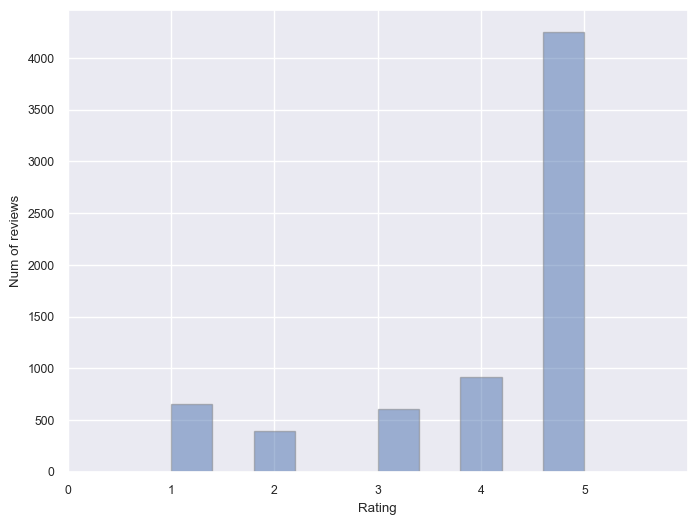

In [83]:
df.review_rating.plot.hist( alpha=0.5, xlim=(0,6), 
                                  xticks=list(range(0, 6, 1)),
                                  figsize=(8,6),  edgecolor = "grey")
plt.xlabel('Rating')
plt.ylabel('Num of reviews')

In [3]:
df['scraped_date_diff_posted'].describe()

count    6820.000000
mean      538.662610
std       493.626145
min         4.000000
25%       192.000000
50%       399.000000
75%       759.250000
max      4264.000000
Name: scraped_date_diff_posted, dtype: float64

In [4]:
df.scraped_date_diff_posted.quantile([i*0.05 for i in range(0,20,1)])

0.00       4.00
0.05      45.00
0.10      82.00
0.15     121.85
0.20     159.00
0.25     192.00
0.30     225.70
0.35     256.00
0.40     294.00
0.45     339.00
0.50     399.00
0.55     453.00
0.60     519.00
0.65     588.00
0.70     684.00
0.75     759.25
0.80     860.00
0.85     969.00
0.90    1126.20
0.95    1443.05
Name: scraped_date_diff_posted, dtype: float64

`~45%ile of reviews is within 1 year of posting`

Text(0, 0.5, 'Num of posts')

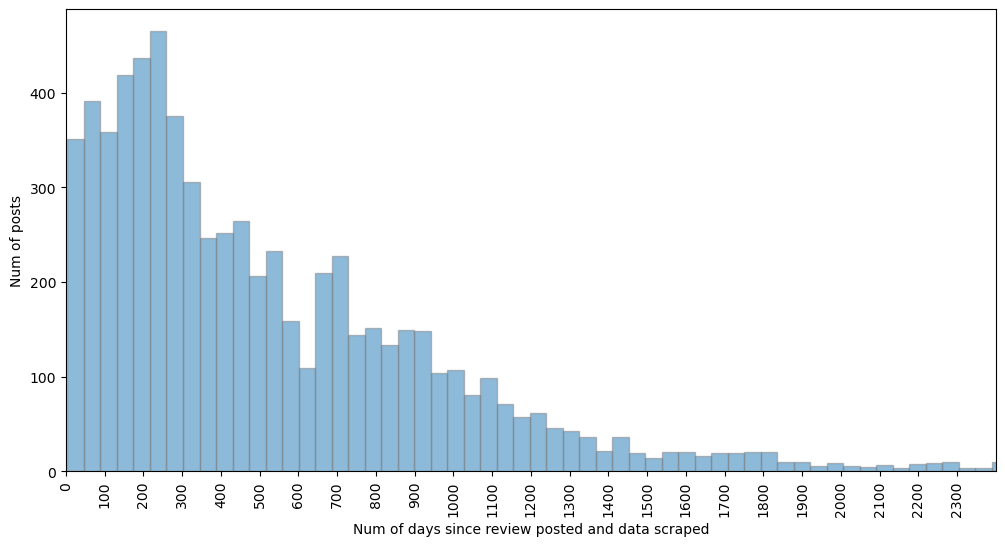

In [5]:
df.scraped_date_diff_posted.plot.hist(bins=100, alpha=0.5, xlim=(0,2400), 
                                  xticks=list(range(0, 2400, 100)), rot=90, 
                                  figsize=(12,6),  edgecolor = "grey")
plt.xlabel('Num of days since review posted and data scraped')
plt.ylabel('Num of posts')

Text(18.448156249999997, 0.5, 'Num of posts')

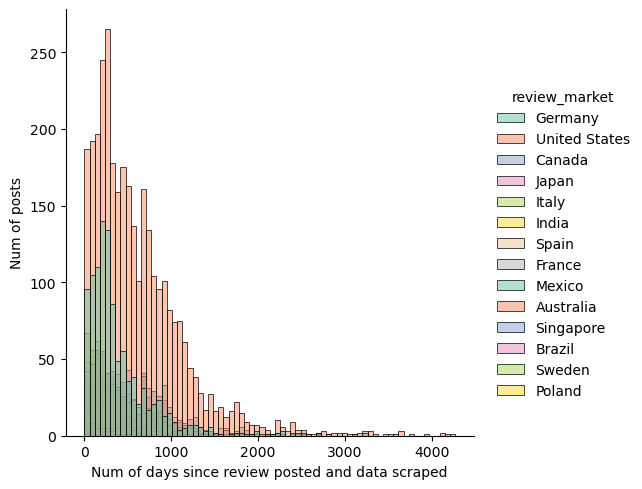

In [6]:
sns.displot(data=df, x="scraped_date_diff_posted", hue="review_market",
           fill=True, common_norm=False, linewidth=0.5, palette='Set2')
plt.xlabel('Num of days since review posted and data scraped')
plt.ylabel('Num of posts')

`These markets had more recent reviews than the rest - USA & DEU`

Text(25.086201388888888, 0.5, 'Num of posts')

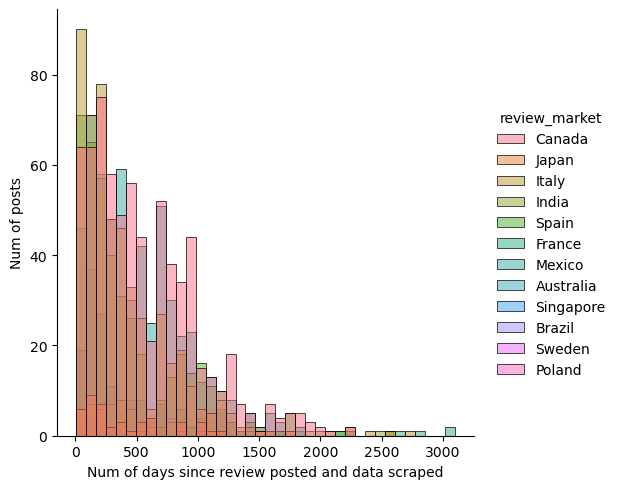

In [7]:
sns.displot(data=df[~df.review_market.isin(['Germany', 'United States'])], x="scraped_date_diff_posted", hue="review_market",
           fill=True, common_norm=False, linewidth=0.5,)
plt.xlabel('Num of days since review posted and data scraped')
plt.ylabel('Num of posts')

`These markets had reviews scraped from a long time ago`

In [8]:
# better to use median for num of days since product was reviewed to keep normal-ness
df.groupby(['review_market']).median()[['scraped_date_diff_posted']]

,scraped_date_diff_posted
review_market,
Australia,700.0
Brazil,185.5
Canada,476.0
France,251.0
Germany,274.0
India,362.0
Italy,266.0
Japan,279.5
Mexico,399.0


#### 1a.Popular markets for shoes

In [9]:
mkt_count_id_df = df.groupby(['review_market']).nunique()[['uniq_id']].sort_values(['uniq_id']).reset_index()
mkt_rating_df = df.groupby(['review_market']).mean()[['review_rating']].reset_index()
mkt_days_since_df = df.groupby(['review_market']).median()[['scraped_date_diff_posted']].reset_index()

In [10]:
mkt_metric_df = mkt_count_id_df.merge(mkt_rating_df).merge(mkt_days_since_df)

In [11]:
mkt_metric_df['log_days'] = mkt_metric_df['scraped_date_diff_posted'].apply(lambda x: np.log10(x))

mkt_metric_df["score"] = (mkt_metric_df['uniq_id']*mkt_metric_df['review_rating'])/(mkt_metric_df['log_days'])

mkt_metric_df = mkt_metric_df.sort_values(['score'], ascending=False).reset_index(drop=True)

In [12]:
mkt_metric_df

,review_market,uniq_id,review_rating,scraped_date_diff_posted,log_days,score
0,United States,3158,3.974738,489.5,2.689753,4666.682949
1,Germany,1052,4.254443,274.0,2.437751,1835.985408
2,Canada,661,4.233859,476.0,2.677607,1045.179935
3,Mexico,537,4.466667,399.0,2.600973,922.193385
4,Italy,505,4.352941,266.0,2.424882,906.533029
5,Spain,407,4.179426,263.0,2.419956,702.916290
6,France,169,4.124260,251.0,2.399674,290.456154
7,India,60,3.816667,362.0,2.558709,89.498274
8,Japan,45,4.239130,279.5,2.446382,77.976736
9,Australia,20,4.714286,700.0,2.845098,33.139707


#### 1b.Popular shoe OVERALL by market

In [13]:
agg_count_id_df = df.groupby(['review_market','product_brand_name', 'product_name']).nunique()[['uniq_id']].sort_values(['uniq_id']).reset_index()
agg_rating_df = df.groupby(['review_market','product_brand_name', 'product_name']).mean()[['review_rating']].reset_index()
agg_days_since_df = df.groupby(['review_market','product_brand_name', 'product_name']).median()[['scraped_date_diff_posted']].reset_index()

In [14]:
agg_metric_df = agg_count_id_df.merge(agg_rating_df).merge(agg_days_since_df)

agg_metric_df['log_days'] = agg_metric_df['scraped_date_diff_posted'].apply(lambda x: np.log10(x))

agg_metric_df["score"] = (agg_metric_df['uniq_id']*agg_metric_df['review_rating'])/(agg_metric_df['log_days'])

agg_metric_df = agg_metric_df.sort_values(['score'], ascending=False).reset_index(drop=True)

In [15]:
agg_metric_df.head(10)

,review_market,product_brand_name,product_name,uniq_id,review_rating,scraped_date_diff_posted,log_days,score
0,United States,adidas,adidas daily 30 skate shoe grey 3 us unisex little kid,9,5.000000,79.0,1.897627,23.713827
1,Germany,superfit,superfit girls emily sandal blue pink 8000 85 uk,10,5.000000,152.0,2.181844,22.916400
2,Germany,ara,ara womens courtyard sneaker rubin 35 uk,9,4.888889,85.0,1.929419,22.804793
3,United States,new balance,new balance boys fresh foam arishi v2 bungee running shoe blackoxygen blueteam red 13 wide little kid,9,4.333333,59.0,1.770852,22.023297
4,Germany,marco tozzi,marco tozzi womens 222378326 damen sneaker rose comb 5 uk,10,5.000000,219.5,2.341435,21.354430
5,Germany,podowell aquitaine,podowell aquitaine unisex adult trainer black 5 uk,10,4.800000,178.0,2.250420,21.329352
6,United States,rocket dog,rocket dog womens giaps001 sneaker black 9 uk,9,5.000000,137.0,2.136721,21.060311
7,Germany,wrezatro,wrezatro mens shoes running shoes breathable nonslip fashion trainers walking tennis trainers sports shoes black size 7 uk,8,4.250000,42.0,1.623249,20.945643
8,Mexico,puma,puma mens respin sneaker white whitelimoges blackhigh risk red 4 uk,9,5.000000,147.0,2.167317,20.762995
9,United States,under armour,under armour ua bps assert 9 ac road running shoe blackwhitewhite 12 uk child,9,4.555556,96.0,1.982271,20.683345


In [16]:
# for individual shoes products we can look at their scores
agg_style_df = agg_metric_df.groupby(['review_market', 
                       'product_name'
                      ])['score'].sum().reset_index().sort_values(by=
                                                                  [ 
                                                                   'score',
                                                                  'review_market'], 
                                                                  ascending=
                                                                  [False, False]).groupby('review_market').head(10).reset_index(drop=True)


In [17]:
disp_df = agg_style_df.merge(df[['product_name', 'review_market', 'url', 'product_shoe_gender']]).drop_duplicates()
disp_df.product_name = disp_df.product_name.apply(lambda x: " ".join(x.split(" ")[:5])+"...")

In [18]:
disp_df[disp_df.review_market=='United States']#.to_clipboard(index=False, header=False)

,review_market,product_name,score,url,product_shoe_gender
0,United States,adidas daily 30 skate shoe...,23.713827,https://www.amazon.co.uk/dp/B082W5GQ5L,unisex
28,United States,new balance boys fresh foam...,22.023297,https://www.amazon.co.uk/dp/B08P2DHZ6W,child
57,United States,rocket dog womens giaps001 sneaker...,21.060311,https://www.amazon.co.uk/dp/B08R2NY443,women
83,United States,under armour ua bps assert...,20.683345,https://www.amazon.co.uk/dp/B0881XD359,child
157,United States,asics mens hyper throw...,19.195063,https://www.amazon.co.uk/dp/B0815QWWSC,men
175,United States,propet womens travelactiv axial sneaker...,19.123503,https://www.amazon.co.uk/dp/B0842VHZ2N,women
185,United States,asics unisexchild contend 6...,18.956698,https://www.amazon.co.uk/dp/B07SPCHZ6H,unisex
195,United States,sas mens journey mesh walking...,18.904514,https://www.amazon.co.uk/dp/B01MG4H26L,men
205,United States,alicegana womens athletic sneakers comfortable...,18.891552,https://www.amazon.co.uk/dp/B089NCNFBR,women
233,United States,jenn ardor womens slip on...,18.866307,https://www.amazon.co.uk/dp/B08SMH4VCC,women


In [19]:
# for brand we need to look at summation level
agg_brand_df = agg_metric_df.groupby(['review_market', 
                       'product_brand_name'
                      ])['score'].sum().reset_index().sort_values(by=
                                                                  [ 
                                                                   'score',
                                                                  'review_market'], 
                                                                  ascending=
                                                                  [False, False]).groupby('review_market').head(10).reset_index(drop=True)


In [20]:
agg_brand_df[agg_brand_df.review_market=='United States']#.to_clipboard(index=False, header=False)

,review_market,product_brand_name,score
0,United States,adidas,918.498167
1,United States,new balance,455.596411
3,United States,reebok,323.952076
4,United States,puma,320.053795
5,United States,skechers,241.403249
7,United States,asics,172.071860
9,United States,merrell,153.512275
10,United States,clarks,143.250595
15,United States,propet,83.709889
16,United States,toddler,82.866796


### 2. Determine the key aspects that consumers appreciate about these popular shoe products.

ONLY ENGLISH REVIEWS FROM USA

What are the popular shoe products? & What do people like about them?

In [21]:
top_styles_reviews = df.drop(['helpful_count', 'scraped_at', 'review_date'], axis=1).merge(agg_style_df).drop_duplicates().sort_values(['score'], ascending=False).reset_index(drop=True)
top_styles_reviews = top_styles_reviews[top_styles_reviews.review_market=='United States']
top_styles_reviews = top_styles_reviews[top_styles_reviews.review_lang=='en']
top_styles_reviews['review_text_len'] = top_styles_reviews['review_text'].apply(lambda x: x.count(' ')+1)
top_styles_reviews['review_title_len'] = top_styles_reviews['review_title'].apply(lambda x: x.count(' ')+1)

In [22]:
top_styles_reviews['review_title_len'].describe()

count    91.00000
mean      3.67033
std       2.56062
min       1.00000
25%       2.00000
50%       3.00000
75%       4.00000
max      13.00000
Name: review_title_len, dtype: float64

In [23]:
review_title_vocab = top_styles_reviews.review_title.str.lower().tolist()

In [24]:
nlp = spacy.load('en_core_web_sm')

##### Review Title - Unigram

In [25]:
doc = nlp(". ".join(review_title_vocab).lower())
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct]

word_freq = Counter(words)
common_words = word_freq.most_common(10)
common_words

[('great', 14),
 ('shoes', 13),
 ('comfortable', 12),
 ('shoe', 12),
 ('perfect', 6),
 ('quality', 6),
 ('comfy', 5),
 ('nice', 5),
 ('fit', 5),
 ('style', 4)]

##### Review Text - Unigram, bigram

In [26]:
review_text_vocab = top_styles_reviews.review_text.str.lower().tolist()

bigram_text = []
bigram_list = []
for rev in review_text_vocab:
    doc = nlp(rev)
    for token in doc:
        if token.is_stop or token.is_digit or token.is_punct or token.is_space or token.text == 'shoe' or token.text == 'buy' or token.text=='shoes':
            pass 
        else: 
            if len(bigram_text) < 2 or token.is_sent_end: # both unigram & bigrams
                bigram_list.append(str(token.text).strip())
                bigram_text.append(str(token.text).strip())
            else:
                bigram_list.append(" ".join(bigram_text).strip())
                bigram_text = []

In [27]:
# five most common tokens
word_freq = Counter(bigram_list)
common_ngrams = word_freq.most_common(50) # has both unigram and bigram

In [28]:
common_ngrams_df = pd.DataFrame(common_ngrams).rename({0: 'word', 1: 'count'}, axis=1)

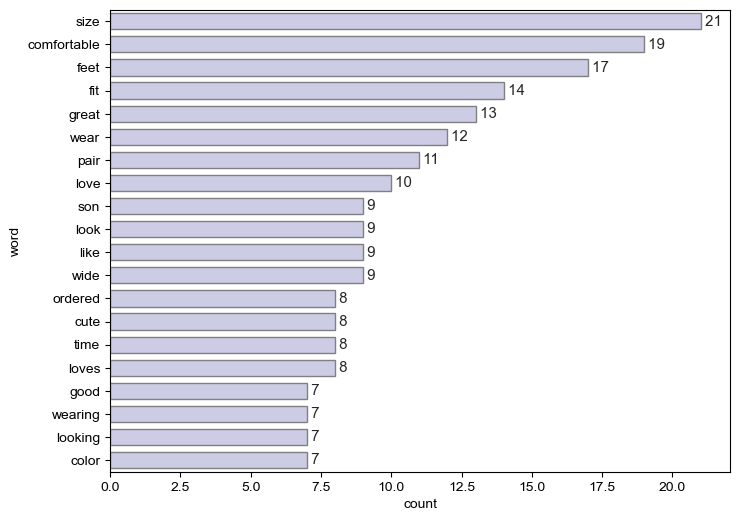

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.9)
sns.barplot(common_ngrams_df.head(20), x='count', y='word', linewidth=1, edgecolor=".5", facecolor=(0.5, 0.5, 0.75, 0.4), width=0.7 )
ax.bar_label(ax.containers[0], fmt=' %.0f')
plt.show()

- Using review title to identify key aspects of the popular shoes doesn't yeild much insight. We need to look at the actual review text to get to the specific aspects of these popular shoes
- Maybe use bigrams for review titles? - doesn't add much specificity either

##### Analysing the Posts which have these top ngrams

In [30]:
common_ngrams_df.head(5)

,word,count
0,size,21
1,comfortable,19
2,feet,17
3,fit,14
4,great,13


In [31]:
def ngram_matcher(rev_text: str):
    common_words = common_ngrams_df.word.tolist()
    keywords = []
    
    for word in common_words:
        if word in rev_text:
            keywords.append(word)
    return list(set(keywords))

In [32]:
top_styles_reviews['top_ngram_list'] = top_styles_reviews['review_text'].apply(lambda x: ngram_matcher(x.lower()))

In [33]:
pct_key_aspects_df = top_styles_reviews.explode(['top_ngram_list']).groupby(['top_ngram_list']).nunique()[['uniq_id']].sort_values(['uniq_id'], ascending=False).reset_index()
pct_key_aspects_df = pct_key_aspects_df.rename({'uniq_id': 'count_of_posts'}, axis=1)
pct_key_aspects_df["perc_posts"] = round(pct_key_aspects_df['count_of_posts']/top_styles_reviews.shape[0]*100, 1)

In [34]:
pct_key_aspects_df.head()

,top_ngram_list,count_of_posts,perc_posts
0,size,27,29.7
1,fit,26,28.6
2,comfortable,25,27.5
3,love,22,24.2
4,wear,22,24.2


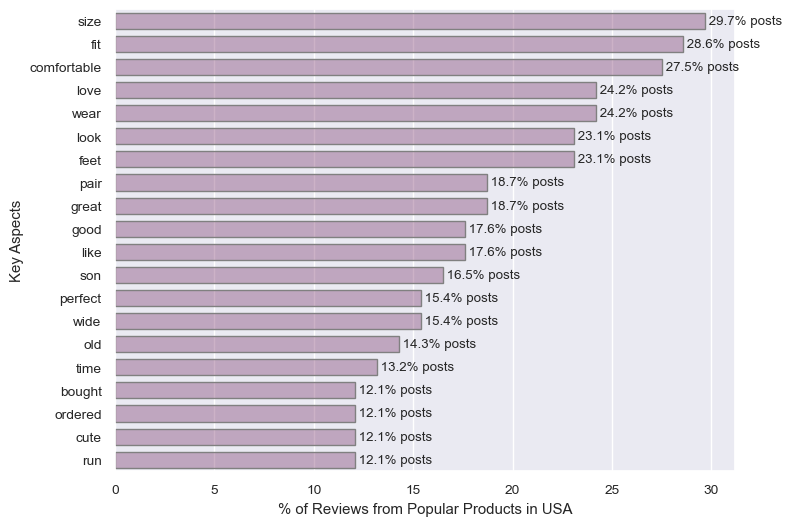

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.8)
sns.barplot(pct_key_aspects_df.head(20), y='top_ngram_list', x='perc_posts', 
            linewidth=1, edgecolor=".5", facecolor=(0.5, 0.25, 0.45, 0.4), width=0.7,
           orient='h')

ax.bar_label(ax.containers[0], fmt = " %.1f%% posts")
plt.ylabel("Key Aspects")
plt.xlabel("% of Reviews from Popular Products in USA")
plt.show()


In [38]:
sample = top_styles_reviews[['review_text', 'score', 'top_ngram_list', 'product_name', 'product_brand_name', 'review_market', 'review_rating', 
                    'scraped_date_diff_posted', 'url', 'checked_user_name']]

In [66]:
sample.shape

(91, 11)

In [86]:
sample[sample['top_ngram_list'].apply(lambda x: 'comfortable' in x)].sample(3)#.product_brand_name.value_counts()

,review_text,score,top_ngram_list,product_name,product_brand_name,review_market,review_rating,scraped_date_diff_posted,url,checked_user_name,parent_possibility,username_gender_detect
238,"Cushiony bottom, soft top and sturdy sole. Great style, perfect fit, comfortable shoe.",18.866307,"[fit, great, perfect, comfortable]",jenn ardor womens slip on sneakers perforated flats comfortable walking fashion tennis shoes camo size 45 uk,jenn ardor,United States,5.0,198,https://www.amazon.co.uk/dp/B08SMH4VCC,Valerie,False,female
7,Kid loves them. Good fit and comfortable.,23.713827,"[loves, comfortable, fit, love, good]",adidas daily 30 skate shoe grey 3 us unisex little kid,adidas,United States,5.0,79,https://www.amazon.co.uk/dp/B082W5GQ5L,Ana,False,female
57,These are rather comfortable and a beachy vibe,21.060311,[comfortable],rocket dog womens giaps001 sneaker black 9 uk,rocket dog,United States,5.0,31,https://www.amazon.co.uk/dp/B08R2NY443,shelley h,False,unknown


##### Review Text - TF-IDF

In [40]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

import string
# lemma = nltk.WordNetLemmatizer()

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove special characters and digits
    text = ''.join(char for char in text if char not in string.punctuation and not char.isdigit())
    text = text.replace("’", "")
    
    # Tokenize the text
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('shoes')
    stop_words.add('shoe')
    stop_words.add('would')
    stop_words.add('like')
    stop_words.add('bought')
    stop_words.add('got')
    stop_words.add('anyways')
    stop_words.add('according')
    stop_words.add('amazon')
    stop_words.add('adding')    
    stop_words.add('adidas')    
    stop_words.add('arrived')    
    
#     for w, vrb in pos_tags:
#         if vrb == 'VB':
#             pass
#         else:
#             stop_words.add(w)
    
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

In [41]:
# Apply text preprocessing to the 'review_text' column
top_styles_reviews['clean_review'] = top_styles_reviews['review_text'].apply(preprocess_text)


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,1), stop_words='english')

# Fit and transform the preprocessed reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(top_styles_reviews['clean_review'])

# Get the feature names (key aspects) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()


In [43]:
# Get the top keywords
top_keywords = []
for row in tfidf_matrix:
    row_data = zip(feature_names, row.toarray().flatten())
    sorted_row = sorted(row_data, key=lambda x: x[1], reverse=True)
    top_keywords.append(sorted_row[:10])  # Change the number to get more or fewer keywords
    
# Count the frequency of each keyword
keyword_counts = Counter([keyword for row in top_keywords for keyword, _ in row])

# Print and analyze the most common keywords
print(keyword_counts.most_common(10))


[('aa', 34), ('able', 28), ('absolutely', 22), ('active', 20), ('actually', 18), ('comfortable', 15), ('fit', 14), ('adorable', 13), ('size', 13), ('great', 10)]


In [44]:
top_styles_reviews.review_text.str.contains('adorable').sum()

1

##### Review Text - Word Embeddings + Topic Clustering

In [45]:
import gensim
from gensim.models import FastText
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


Starting from the beginning, gensim’s word2vec expects a sequence of sentences as its input. Each sentence a list of words (utf8 strings):

In [46]:
sent_sequ = [rev.split(' ') for rev in top_styles_reviews['clean_review'].tolist()]

In [47]:
# Word Embeddings
model = FastText(sent_sequ, vector_size=100, window=3, min_count=5, workers=4)

# Clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters,  random_state=42, n_init='auto')

In [48]:
def sent_embedding(text: str, model: gensim.models.word2vec.Word2Vec):
    
    wv_list = []
    
    for word in text.split(' '):
        if word in model.wv.key_to_index.keys():
            wv_list.append(model.wv[word])
        else:
            pass
    return np.mean(wv_list, axis=0)

In [49]:
top_styles_reviews['sent_emb'] = top_styles_reviews['clean_review'].apply(lambda x: sent_embedding(x, model))

In [50]:
top_styles_reviews = top_styles_reviews[top_styles_reviews['sent_emb'].apply(lambda x: x.shape)==(100,)]

In [51]:
top_styles_reviews['clusters'] = kmeans.fit_predict(np.stack(top_styles_reviews['sent_emb'].to_numpy(), axis=0))


In [52]:
top_styles_reviews['clusters'].value_counts()

1    67
2    23
0     1
Name: clusters, dtype: int64

In [53]:
def get_top_keywords(df, cluster):
    cluster_data = df[df['clusters'] == cluster]
    all_words = [word for sublist in cluster_data['clean_review'] for word in sublist.split(" ")]
    word_freq = pd.Series(all_words).value_counts()
    top_keywords = word_freq.head(10)
    return top_keywords

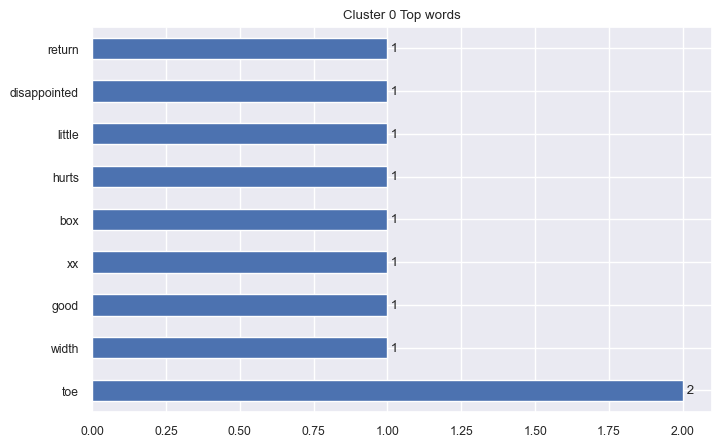

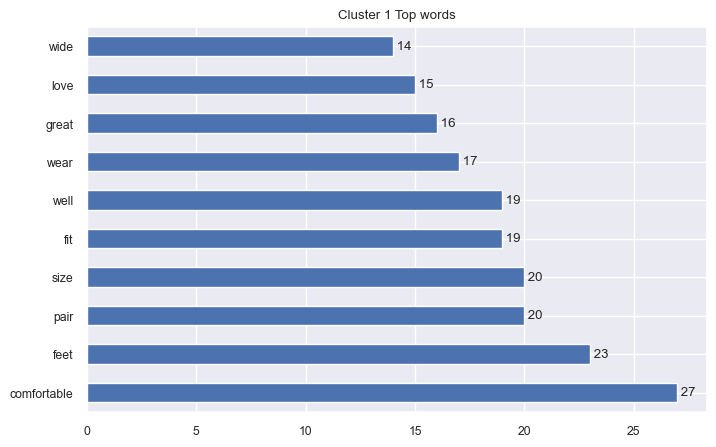

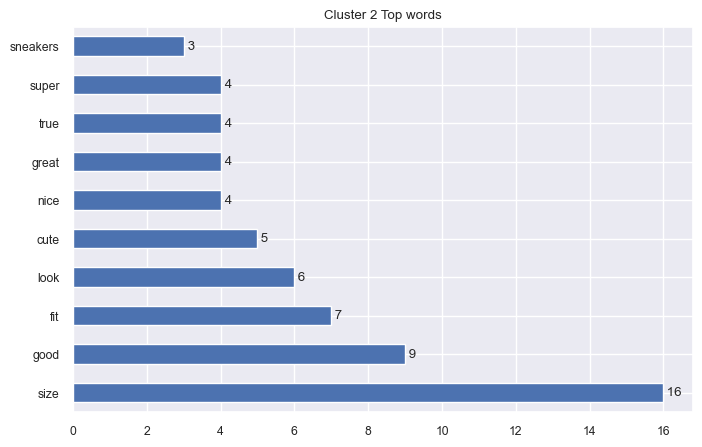

In [54]:
# Example Word Cloud (install the wordcloud package: pip install wordcloud)
from wordcloud import WordCloud
for cluster in range(num_clusters):
    words = get_top_keywords(top_styles_reviews, cluster)
    fig, ax = plt.subplots(figsize=(8, 5))
    words.plot(kind='barh')
    plt.title(f"Cluster {cluster} Top words")
    ax.bar_label(ax.containers[0], fmt=' %.0f')
    plt.show()


### 3. Consumer Profiles

- Using shoe gender as a proxy for whether the consumer is a parent or not -> not reliable (x)
- Identify gender through user name if provided -> using a gender detection package in python -> NOT USEFUL
- [x] Based on language used in reviews 'son', 'daughter', 'child' -> identify if they are a parent or not.

In [55]:
sample['parent_possibility'] = sample['review_text'].apply(lambda x:('kids' in x) or ('kid ' in x) or (' son' in x) or ('daughter' in x))

In [56]:
sample['parent_possibility'].value_counts(normalize=True)*100

False    78.021978
True     21.978022
Name: parent_possibility, dtype: float64

In [60]:
import gender_guesser.detector as gender
d = gender.Detector()

In [68]:
sample['username_gender_detect'] = sample.checked_user_name.apply(lambda x: d.get_gender(x))

In [69]:
sample['username_gender_detect'].value_counts()

unknown          80
female            8
male              2
mostly_female     1
Name: username_gender_detect, dtype: int64